In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

### Load data

In [4]:
stack = 'MD589'
dataFolderName = 'NoCoords'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [22]:
section_valid_list = fun_get_valid_section_list(stack)
section_load_list = list(section_valid_list)

# Load blob data
typical_blob_props = collections.defaultdict(dict)
matched_blob_props = collections.defaultdict(dict)
false_typical_blob_props = collections.defaultdict(dict)
false_matched_blob_props = collections.defaultdict(dict)
for tempProp in scan_parameters['prop_to_save']:
    for tempSec in section_valid_list:
        try:
            typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='typical')
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_typical')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
            
for tempProp in ['section', 'TBID']:
    for tempSec in section_valid_list:
        try:
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
# Get relation between TBID and matched blob idx
TBID_to_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(len(typical_blob_props[tempSec]['area'])):
        TBID_to_matched_blob[tempSec][tempBID] = np.where(matched_blob_props[tempSec]['TBID']==tempBID)[0]
        
TBID_to_false_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(len(false_typical_blob_props[tempSec]['area'])):
        TBID_to_false_matched_blob[tempSec][tempBID] = np.where(false_matched_blob_props[tempSec]['TBID']==tempBID)[0]

TBID_to_false_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(len(false_typical_blob_props[tempSec]['area'])):
        TBID_to_false_matched_blob[tempSec][tempBID] = np.where(false_matched_blob_props[tempSec]['TBID']==tempBID)[0]

1. Get blobs in 7N 
2. Construct training dataset
3. Implement modified perceptron 

In [23]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [24]:
structure_name = '7N'
TBID_in_structure = collections.defaultdict(dict)
for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
    TBID_in_structure[tempSec][structure_name] =  np.where(fun_blobs_in_polygen(typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]


# Training set of 7N

In [40]:
scan_parameters['training_props'] = training_props = ['area', 'eccentricity', 'compactness']

In [25]:
TBID_in_structure[152][structure_name]

array([7351, 7354, 7364, 7374, 7380])

In [29]:
len(typical_blob_props[152]['area'])

7438

In [30]:
tempSec = 152
TBID_in_structure[tempSec][structure_name]

array([7351, 7354, 7364, 7374, 7380])

In [31]:
matched_blob_props[tempSec]['TBID']

array([   0,    0,    0, ..., 7435, 7436, 7437], dtype=int16)

# Whole Brainstem matching results

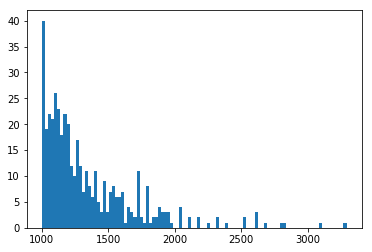

In [24]:
# 
temp = false_matched_blob_props[152]['area']
plt.hist(temp[temp>1000], bins=100);

In [7]:
# margin = 10
# bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
# bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# # bbox_7N = bboxs_7N[154]
# scan_parameters['crop_range_mmxx'] = bbox_7N
# scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
# scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
# scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
# scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [8]:
# Get avaliable sections:
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
load_section_num = 100
load_start_section = 152 - section_begin
all_valid_section = fun_get_valid_section_list(stack=stack)
# secList = all_valid_section[load_start_section:load_section_num + load_start_section]
# secList = list(set(all_valid_section).intersection(sectionList_7N))
secList = all_valid_section
scan_parameters['secList'] = secList

In [139]:
# # loading data
# image = {}
# for tempSec in secList:
#     try:
#         image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
#     except:
#         sys.stderr.write('Cannot import section %d...\n'%tempSec)
#         continue